In [1]:
BATCH_SIZE = 32
IMAGE_SIZE = 64
EPOCHS = 10

## Загрузка данных

In [2]:
from google.colab import drive
from pathlib import Path


drive.mount('/content/drive/')

path = Path("/content/drive/My Drive/Skillbox/emotions")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()

Mounted at /content/drive/


In [3]:
import zipfile

with zipfile.ZipFile("/content/drive/My Drive/Skillbox/emotions/train.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

with zipfile.ZipFile("/content/drive/My Drive/Skillbox/emotions/test_kaggle.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [4]:
import os
import shutil


folder_path = "/content/train"

# Создание подпапок для тренировочного и тестового наборов данных
train_folder = '/content/train_data'
test_folder = '/content/test_data'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)


# Получение списка подпапок в исходной папке
subfolders = os.listdir(folder_path)

# Разделение каждой подпапки на тренировочный и тестовый наборы данных
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    subfolder_train_path = os.path.join(train_folder, subfolder)
    subfolder_test_path = os.path.join(test_folder, subfolder)

    os.makedirs(subfolder_train_path, exist_ok=True)
    os.makedirs(subfolder_test_path, exist_ok=True)

    # Получение списка файлов в текущей подпапке
    files = os.listdir(subfolder_path)
    # Разделение файлов на тренировочный и тестовый наборы данных
    num_train_files = int(0.75 * len(files))  # 75% для тренировочного набора
    train_files = files[:num_train_files]
    test_files = files[num_train_files:]

    # Копирование файлов в соответствующие подпапки
    for file in train_files:
        shutil.copy(os.path.join(subfolder_path, file), os.path.join(subfolder_train_path, file))

    for file in test_files:
        shutil.copy(os.path.join(subfolder_path, file), os.path.join(subfolder_test_path, file))


## Формирование датагенераторов

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_folder_path = '/content/train_data'
test_folder_path = '/content/test_data'

# Создание генераторов изображений для обучения и тестирования
train_datagen = ImageDataGenerator(rescale=1./255,)
test_datagen = ImageDataGenerator(rescale=1./255,)

common = {
    'batch_size': BATCH_SIZE,
    'target_size': (IMAGE_SIZE, IMAGE_SIZE),
    'class_mode': "categorical",
}

train_image_generator = train_datagen.flow_from_directory(
    train_folder_path, shuffle=True, **common)

test_image_generator = test_datagen.flow_from_directory(
    test_folder_path, shuffle=True, **common)

Found 37533 images belonging to 9 classes.
Found 12514 images belonging to 9 classes.


In [6]:
import numpy as np

sample_images, sample_labels = next(train_image_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE, 9), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


## Настройка колбеков и обучение модели

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# КОЛБЕКИ
cpt_filename = "best_cpt_first_model.hdf5"
cpt_path =str(path / cpt_filename)

early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential


def make_model():
    """Создание экземпляра модели"""
    model = Sequential()

    model.add(BatchNormalization(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.25))

    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(9, activation='softmax'))

    return model

In [ ]:
model = make_model()

In [ ]:
# Компиляция модели
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Вывод структуры модели
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Bat  (None, 64, 64, 3)         12        
 chNormalization)                                                
                                                                 
 batch_normalization_9 (Bat  (None, 64, 64, 3)         12        
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 batch_normalization_10 (Ba  (None, 64, 64, 128)       512       
 tchNormalization)                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       147584    
                                                      

In [10]:
!pip install livelossplot

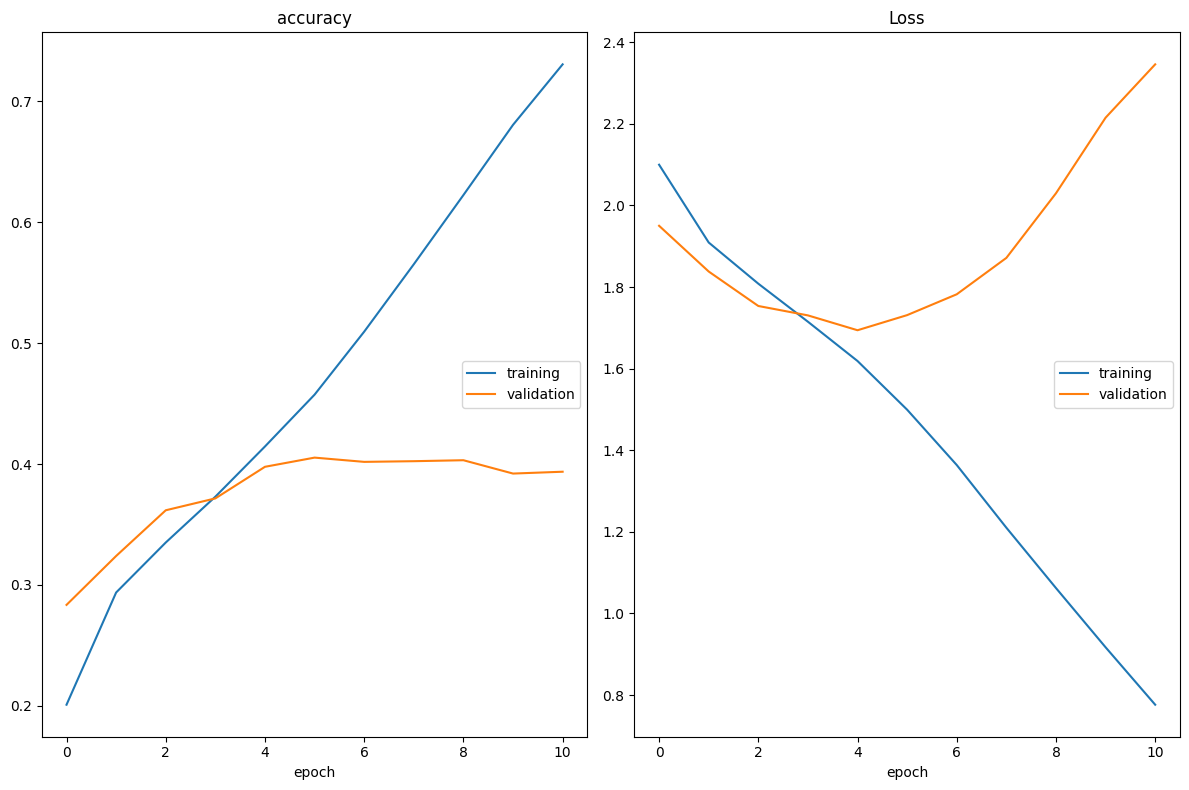

accuracy
	training         	 (min:    0.201, max:    0.731, cur:    0.731)
	validation       	 (min:    0.284, max:    0.405, cur:    0.394)
Loss
	training         	 (min:    0.776, max:    2.100, cur:    0.776)
	validation       	 (min:    1.694, max:    2.346, cur:    2.346)

Epoch 11: val_accuracy did not improve from 0.40531
1173/1173 [==============================] - 163s 139ms/step - loss: 0.7764 - accuracy: 0.7305 - val_loss: 2.3459 - val_accuracy: 0.3936


In [ ]:
from livelossplot.tf_keras import PlotLossesCallback

# EPOCHS = 7
history = model.fit_generator(
    train_image_generator,
    epochs=EPOCHS,
    validation_data=test_image_generator,
    callbacks=[PlotLossesCallback(), checkpoint, early_stopping_callback])

Примерно с 5 эпохи пошло переобучение. Возможно стоило бы добавить регуляризацию, увеличить процент дропаута, добавить аугментацию данных. Максимальная точность порядка 40%, попытаемся это улучшить в следующем ноутбуке.

## Попытка использования аугментации

In [ ]:
# Аугментация данных
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=40,
    # width_shift_range=0.2,    слишком долго
    # height_shift_range=0.2,
    # shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# common = {
#     'batch_size': BATCH_SIZE,
#     'target_size': (IMAGE_SIZE, IMAGE_SIZE),
#     'class_mode': "categorical",
# }

train_image_generator_aug = train_datagen_aug.flow_from_directory(
    train_folder_path, shuffle=True, **common)

Found 37533 images belonging to 9 classes.


In [ ]:
sample_images, sample_labels = next(train_image_generator_aug)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE, 9), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


In [ ]:
# КОЛБЕКИ 2
cpt_filename_aug = "best_cpt_first_model_aug.hdf5"
cpt_path_aug = str(path / cpt_filename_aug)

# early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5)

checkpoint_aug = tf.keras.callbacks.ModelCheckpoint(cpt_path_aug,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

In [ ]:
model_aug = make_model()

In [ ]:
# Компиляция модели
model_aug.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Вывод структуры модели
model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Bat  (None, 64, 64, 3)         12        
 chNormalization)                                                
                                                                 
 batch_normalization_7 (Bat  (None, 64, 64, 3)         12        
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 batch_normalization_8 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       147584    
                                                      

In [1]:
from livelossplot.tf_keras import PlotLossesCallback


history_aug = model_aug.fit_generator(
    train_image_generator_aug,
    epochs=EPOCHS,
    steps_per_epoch=50,
    validation_data=test_image_generator,
    callbacks=[PlotLossesCallback(), checkpoint_aug, early_stopping_callback])

Пробовала делать аугментацию по-разному, но не хватало всегда времени пользования Т4. Перешла на файнтьюнинг в следующем ноутбуке.